In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Input
from tensorflow.keras.utils import plot_model
from skimage.draw import random_shapes
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
n = 10000
x_test = []
y_test = []
yl_test = []
x_train = []
y_train = []
yl_train = []

shape = np.array((44, 44))

def rand(n, type_):
    while True:
        img, lbl = random_shapes(shape-6, multichannel=None, 
                                 max_shapes=1, shape=type_, min_size=10, 
                                intensity_range=[2, 254])
        new_img = np.zeros(shape)
        new_img[3:-3, 3:-3] = img
        img = new_img
        img[img == 255] = 0
        img[img > 0] = 1
        if len(lbl) == n:
            return img, lbl

for i in range(n):
    type_ = "rectangle"
    if i % 2 == 0:
        type_ = "circle"
    img, lbl = rand(1, type_)
    x_train.append(img)
    y_train.append(np.array(lbl[0][1]).flatten())
    yl_train.append(0 if type_=="rectangle" else 1)

for i in range(int(n * 0.2)):
    type_ = "rectangle"
    if i % 2 == 0:
        type_ = "circle"
    img, lbl = rand(1, type_)
    x_test.append(img)
    y_test.append(np.array(lbl[0][1]).flatten())
    yl_test.append(0 if type_=="rectangle" else 1)


x_test = np.array(x_test)
y_test = np.array(y_test).reshape(len(y_test), -1)
yl_test = np.array(yl_test).reshape(len(yl_test), -1)
x_train = np.array(x_train)
y_train = np.array(y_train).reshape(len(y_train), -1)
yl_train = np.array(yl_train).reshape(len(y_train), -1)

y_test = y_test / shape[0]
y_train = y_train / shape[0]

x_test = x_test.reshape(*x_test.shape, 1)
x_train = x_train.reshape(*x_train.shape, 1)

In [ ]:
x_train.shape

(10000, 44, 44, 1)

TypeError: ignored

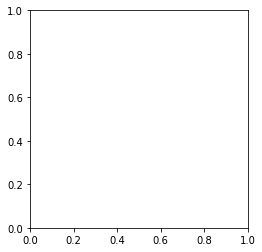

In [ ]:
plt.imshow(x_train[1])

In [ ]:
inp = Input(shape=x_train.shape[1:])

cov_ = Conv2D(filters=16, kernel_size=(4, 4), activation="relu")(inp)
cov_ = MaxPool2D(pool_size=(2, 2))(cov_)

cov_ = Conv2D(filters=32, kernel_size=(4, 4), activation="relu")(cov_)
cov_ = MaxPool2D(pool_size=(2, 2))(cov_)

cov_ = Conv2D(filters=64, kernel_size=(4, 4), activation="relu")(cov_)
cov_ = MaxPool2D(pool_size=(2, 2))(cov_)

flatten = Flatten()(cov_)

bbox = Dense(128, activation="relu")(flatten)
bbox = Dense(64, activation="relu")(bbox)
bbox = Dense(32, activation="relu")(bbox)

class_ = Dense(256, activation='relu')(flatten)
class_ = Dense(128, activation='relu')(class_)
class_ = Dense(1, activation='sigmoid', name='class_output')(class_)

bbox = Dense(4, activation="sigmoid", name="bbox_output")(bbox)

model = Model(inp, [class_, bbox])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 44, 44, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 41, 41, 16)   272         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 20, 20, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 17, 17, 32)   8224        ['max_pooling2d[0][0]']          
                                                                                              

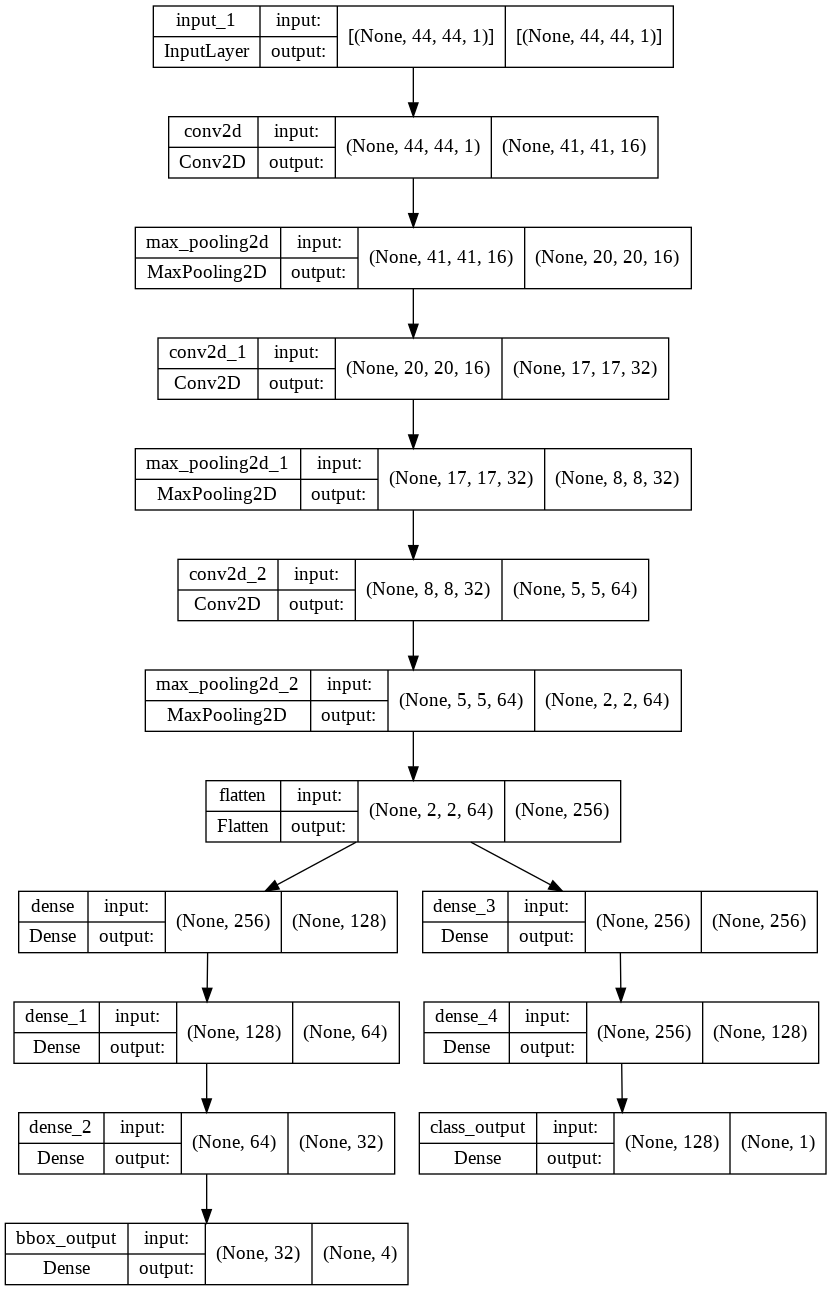

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
def iou(bbox1, bbox2):
    y1, y2, x1, x2 = bbox1[:, 0], bbox1[:, 1], bbox1[:, 2], bbox1[:, 3]
    y3, y4, x3, x4 = bbox2[:, 0], bbox2[:, 1], bbox2[:, 2], bbox2[:, 3]
    inter_w = tf.reduce_min(tf.stack([x2, x4]), 0) - tf.reduce_max(tf.stack([x1, x3]), 0)
    inter_h = tf.reduce_min(tf.stack([y2, y4]), 0) - tf.reduce_max(tf.stack([y1, y3]), 0)
    pos = tf.logical_or(inter_w <= 0, inter_h <= 0)
    inter_area = inter_w * inter_h
    union_area = (y2-y1) * (x2-x1) + (y4-y3) * (x4-x3) - inter_area
    result = tf.where(pos, 0.0, inter_area / union_area)
    return 1 - result

In [ ]:
tf.keras.backend.clear_session()

model.compile(
    "adam", 
    loss={
        
        'bbox_output': iou,
        "class_output": 'binary_crossentropy',
    }, 
    metrics=["accuracy"]
)

model.fit(
    x_train, {"class_output": yl_train, 'bbox_output':y_train}, 
    epochs=10, batch_size=64, verbose=2,
    validation_data=(x_test, {"class_output": yl_test, 'bbox_output': y_test})
)

Epoch 1/10
157/157 - 16s - loss: 0.8747 - class_output_loss: 0.1882 - bbox_output_loss: 0.6866 - class_output_accuracy: 0.9107 - bbox_output_accuracy: 0.5466 - val_loss: 0.3166 - val_class_output_loss: 0.0076 - val_bbox_output_loss: 0.3090 - val_class_output_accuracy: 0.9970 - val_bbox_output_accuracy: 0.8255 - 16s/epoch - 102ms/step
Epoch 2/10
157/157 - 14s - loss: 0.2528 - class_output_loss: 0.0349 - bbox_output_loss: 0.2179 - class_output_accuracy: 0.9945 - bbox_output_accuracy: 0.9047 - val_loss: 0.6945 - val_class_output_loss: 0.4111 - val_bbox_output_loss: 0.2834 - val_class_output_accuracy: 0.8930 - val_bbox_output_accuracy: 0.8790 - 14s/epoch - 88ms/step
Epoch 3/10
157/157 - 14s - loss: 0.1900 - class_output_loss: 0.0108 - bbox_output_loss: 0.1792 - class_output_accuracy: 0.9969 - bbox_output_accuracy: 0.9184 - val_loss: 0.1493 - val_class_output_loss: 2.0712e-04 - val_bbox_output_loss: 0.1491 - val_class_output_accuracy: 1.0000 - val_bbox_output_accuracy: 0.9300 - 14s/epoch - 

In [ ]:
import h5py

with h5py.File('rc_dataset.h5', 'w')  as f:
  f['x_test'] = x_test
  f['y_test'] = y_test
  f['x_train'] = x_train
  f['y_train'] = y_train
  f['yl_test'] = yl_test
  f['yl_train'] = yl_train

[11. 30. 14. 33.]
[11. 30. 14. 33.]
[1.]


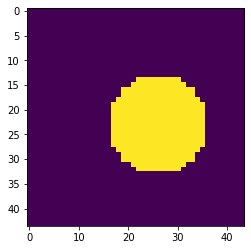

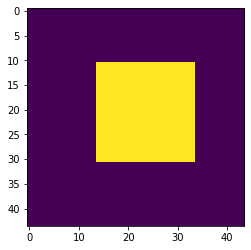

In [ ]:
predictions = model.predict(x_test)
classes = predictions[0][:]
bboxes = np.round(predictions[1][:,:] * shape[0])

i = 400
# print(predictions* shape[0])
print(y_test[i] * shape[0])
print(bboxes[i])

print(classes[i])

img = np.zeros((44,44))

img[int(bboxes[i,0]):int(bboxes[i,1])+1,int(bboxes[i,2]):int(bboxes[i,3])+1] = 1

plt.imshow(x_test[i].reshape((44,44)))
plt.show()
plt.imshow(img)
plt.show()

In [ ]:
!python main.py 

100% 323M/323M [03:34<00:00, 1.58MB/s]
main.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation.filename[idx] = new_filename
100% 180M/180M [01:58<00:00, 1.59MB/s]
 27% 71.7M/264M [00:46<02:04, 1.61MB/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tqdm/std.py", line 1533, in wrapattr
    yield CallbackIOWrapper(t.update, stream, method)
  File "main.py", line 30, in download_zip
    chunk = raw.read(CHUNK_SIZE)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "main.py", line 155, in <module>
    zip_file = download_zip(url)
  File "main.py", line 34, in download_zip
    break
  File "/usr/lib/python3.7/contextlib.py", line 130, in __exit__
    self.gen.throw(type, value, tra